Missing values: 0
R² Score:  0.8628
MAE:       10.80 fatalities
RMSE:      15.82 fatalities


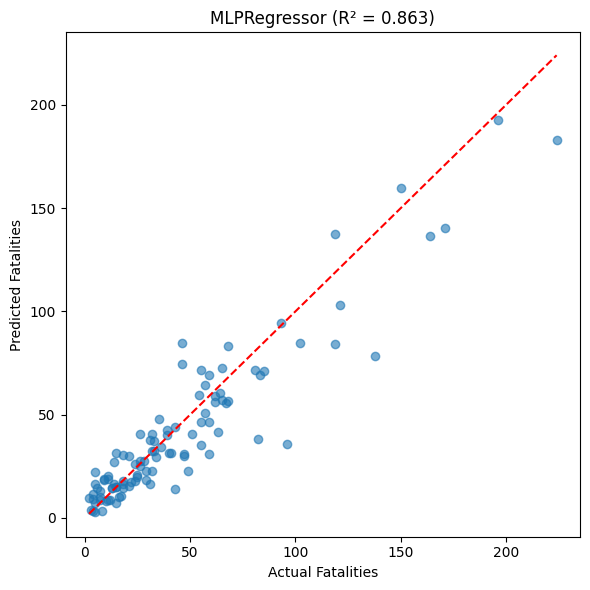

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ----------------------------
# 1. Load data
# ----------------------------
df = pd.read_csv('Nigeria Crash Data P.csv')

# ----------------------------
# 2. Define target
# ----------------------------
target = 'Num_Killed'
y = df[target].values

# ----------------------------
# 3. Select features (no leakage from target)
# ----------------------------
# Raw numeric crash factors
num_features = [
    'Total_Crashes', 'Num_Injured', 'Total_Vehicles_Involved',
    'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors',
    'Quarter_Num', 'Year', 'Quarter_Sin', 'Quarter_Cos'
]

# State dummy columns (37 columns, all start with 'State_' except the original 'State' column)
state_dummies = [col for col in df.columns if col.startswith('State_') and col != 'State_Encoded']

# Region dummy columns (5 binary columns for regions, excluding the numeric encoding)
region_dummies = [col for col in df.columns if col.startswith('Region_') and col != 'Region_Encoded']

# Combine all feature names
feature_cols = num_features + state_dummies + region_dummies
X = df[feature_cols].copy()

# Check for any missing values (none in this dataset)
print(f"Missing values: {X.isnull().sum().sum()}")

# Convert boolean dtypes to int (MLPRegressor expects numeric)
for col in state_dummies + region_dummies:
    X[col] = X[col].astype(int)

# ----------------------------
# 4. Train / test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 5. Scale features
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 6. Train MLPRegressor
# ----------------------------
mlp = MLPRegressor(
    hidden_layer_sizes=(100,),      # one hidden layer with 100 neurons
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,            # prevent overfitting
    validation_fraction=0.1
)

mlp.fit(X_train_scaled, y_train)

# ----------------------------
# 7. Evaluate
# ----------------------------
y_pred = mlp.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.2f} fatalities")
print(f"RMSE:      {rmse:.2f} fatalities")

# Optional: plot predictions vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.title(f'MLPRegressor (R² = {r2:.3f})')
plt.tight_layout()
plt.show()